In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import datetime 
import os
import warnings
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
dtype_dict = {
    'Date': str,  
    'Time': str,  
    'Global_active_power': float,
    'Global_reactive_power': float,
    'Voltage': float,
    'Global_intensity': float,
    'Sub_metering_1': float,
    'Sub_metering_2': float,
    'Sub_metering_3': float
}

na_values = ['?', 'NA']
df = pd.read_csv('household_power_consumption.txt', sep=';', dtype=dtype_dict, na_values=na_values)


In [3]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.drop(['Date', 'Time'], axis=1, inplace=True)


In [4]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'DateTime'],
      dtype='object')

In [5]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [6]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2075259
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,2008-12-06 07:12:59.999994112
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2006-12-16 17:24:00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2007-12-12 00:18:30
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2008-12-06 07:13:00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,2009-12-01 14:07:30
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,2010-11-26 21:02:00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,NaN


In [7]:
na_counts = df.isna().sum()

print("Number of NaN values per column:")
print(na_counts)

Number of NaN values per column:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
DateTime                     0
dtype: int64


In [8]:
df.shape

(2075259, 8)

In [9]:
rows_with_na = df[df.isna().any(axis=1)]
rows_with_na

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
6839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-12-21 11:23:00
6840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-12-21 11:24:00
19724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-12-30 10:08:00
19725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-12-30 10:09:00
41832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-01-14 18:36:00
...,...,...,...,...,...,...,...,...
1990185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-28 19:09:00
1990186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-28 19:10:00
1990187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-28 19:11:00
1990188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-09-28 19:12:00


In [10]:
numeric_cols = df.select_dtypes(include='number').columns

rolling_mean = df[numeric_cols].rolling(window=5, min_periods=1).mean()

df[numeric_cols] = df[numeric_cols].fillna(rolling_mean)

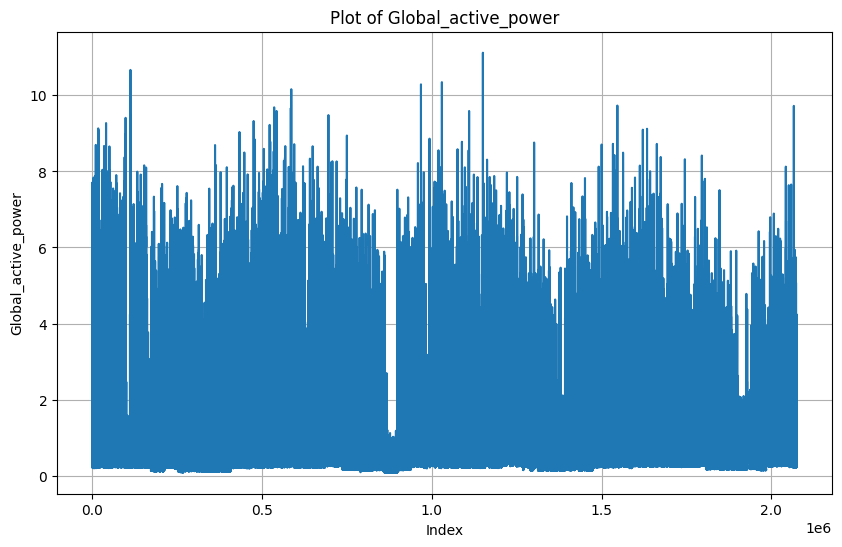

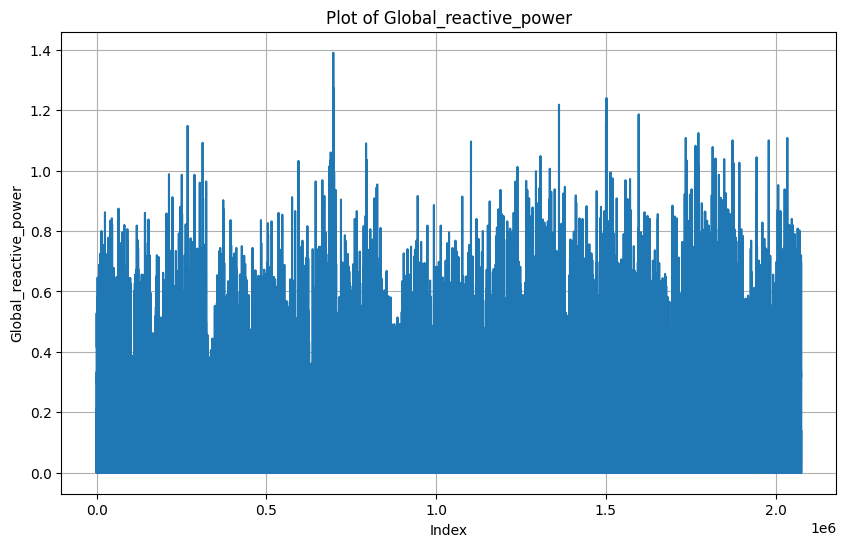

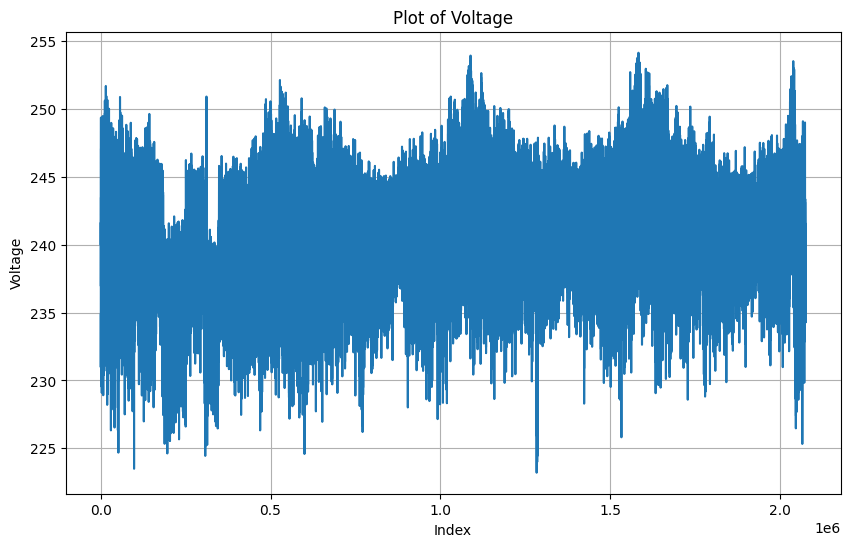

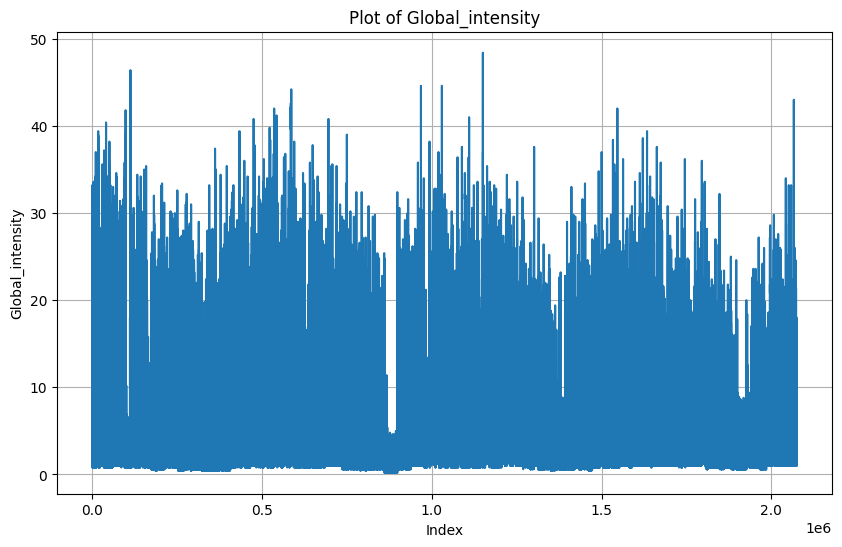

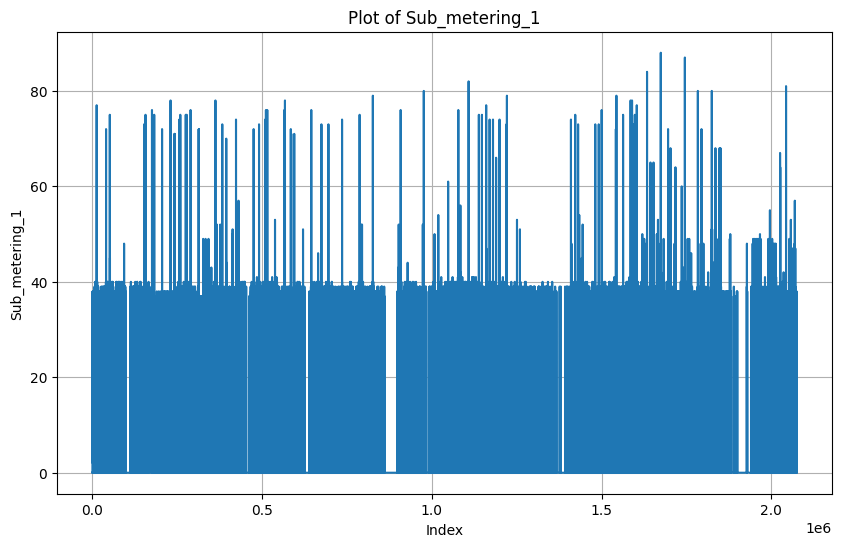

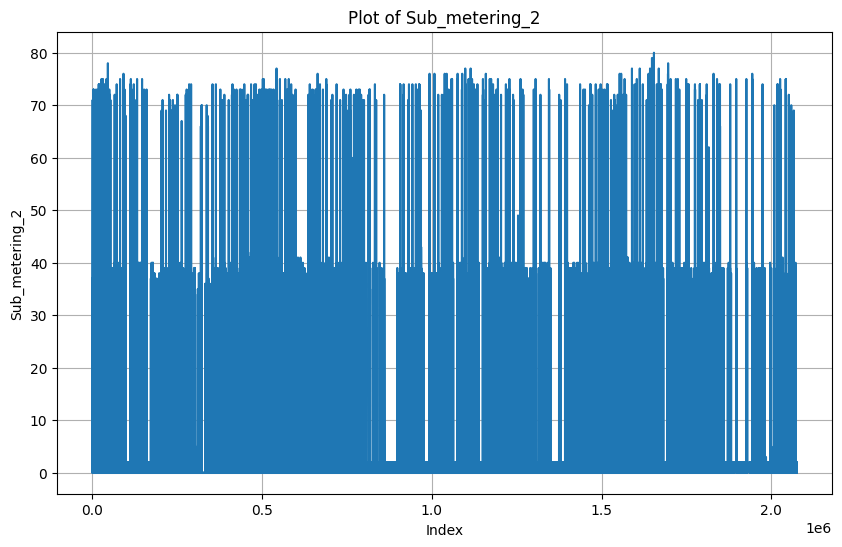

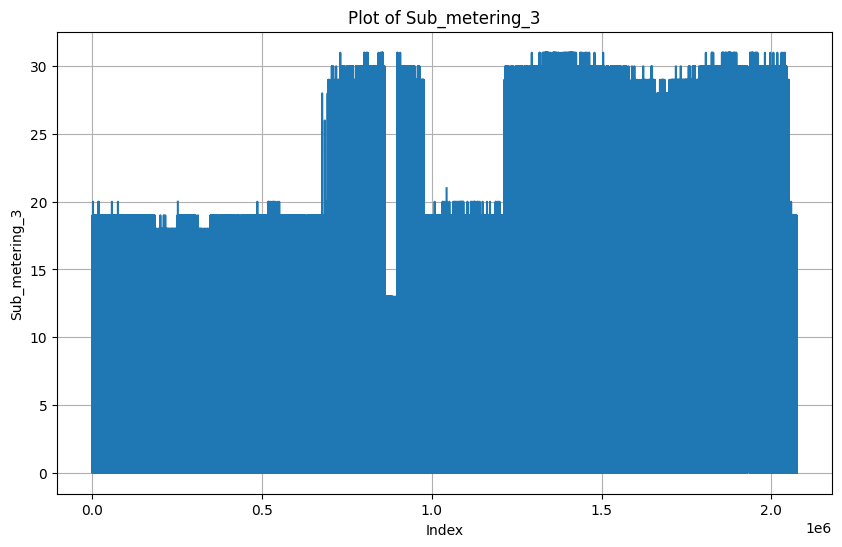

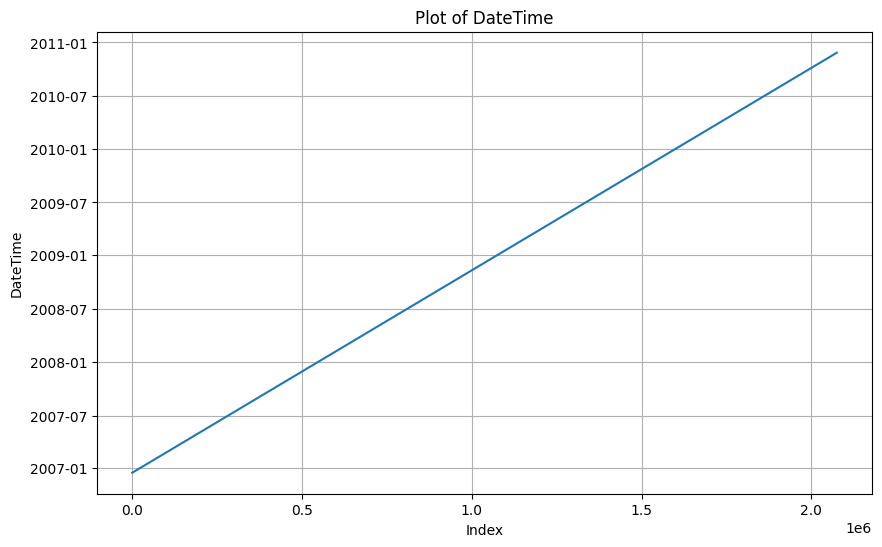

In [11]:
for column in df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df[column])
    plt.title(f'Plot of {column}')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()


In [12]:
df['Sub_metering_4'] = (df.iloc[:, 0] * 1000 / 60) - (df.iloc[:, 4] + df.iloc[:, 5] + df.iloc[:, 6])

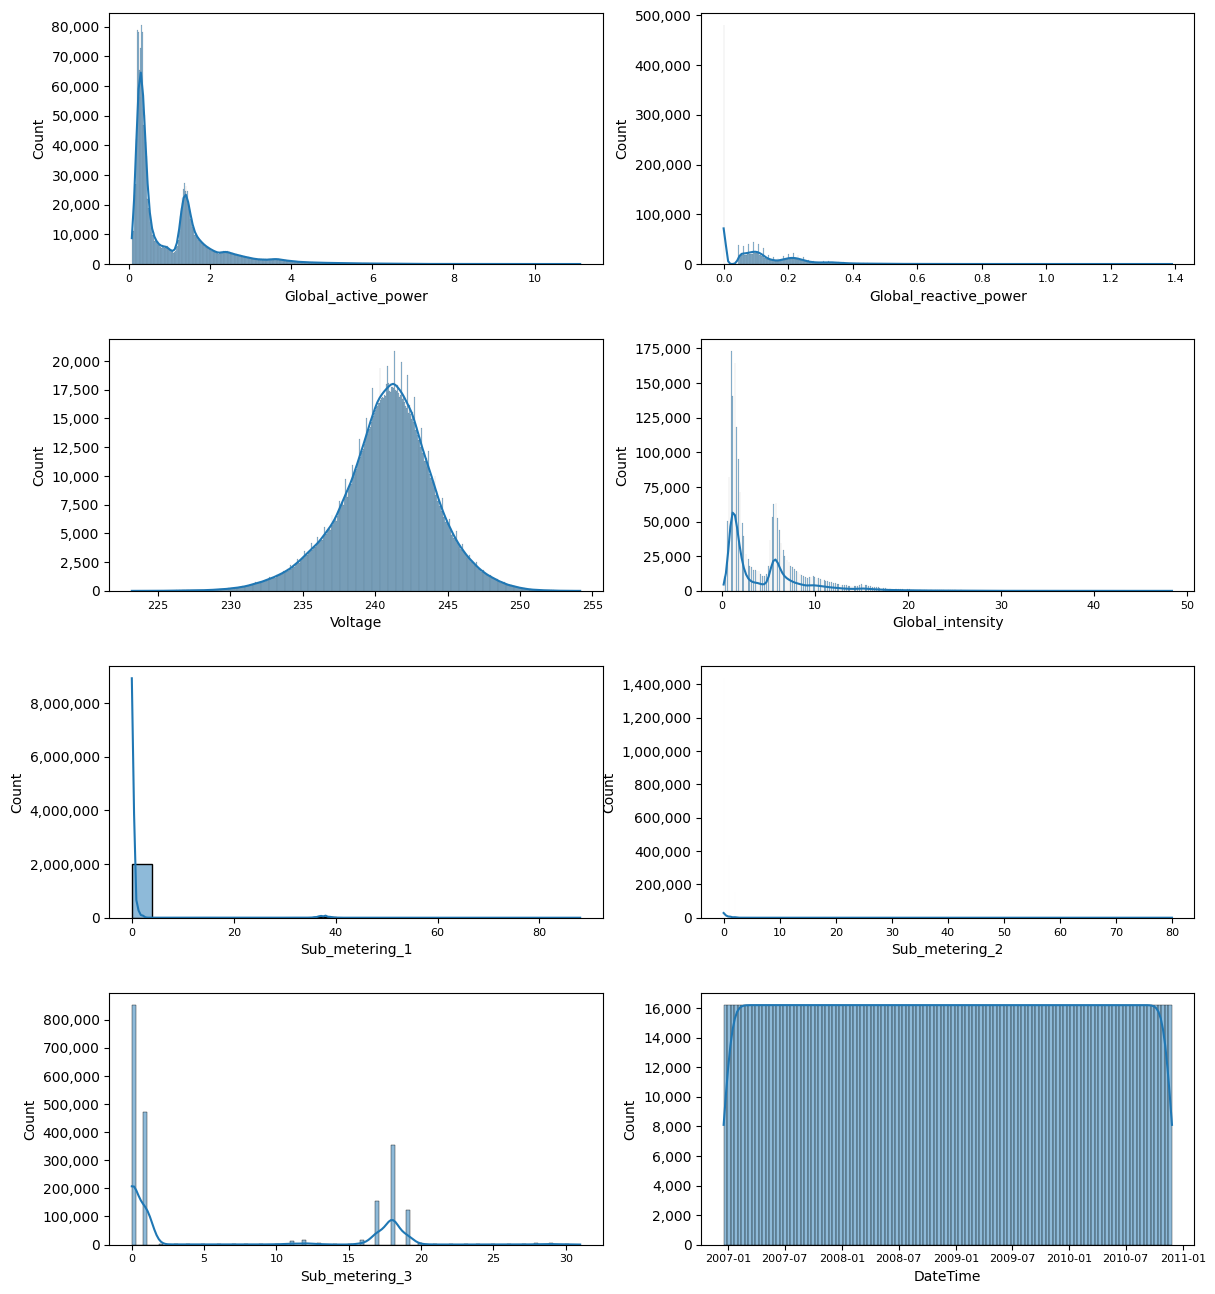

In [13]:
columns = df.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=df, ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3);

## per hour data

In [14]:
df.set_index('DateTime', inplace=True)

# Resample the data to daily frequency and aggregate using mean
df_daily = df.resample('D').mean()

In [15]:
df_daily

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
DateTime,,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394,37.073064
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583,25.657407
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,13.214190
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,9.119375
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972,14.156111
...,...,...,...,...,...,...,...,...
2010-11-22,1.417733,0.098857,240.197118,6.014167,3.371528,1.465278,7.038889,11.753194
2010-11-23,1.095511,0.095451,240.575528,4.674444,1.299306,0.318056,5.285417,11.355741
2010-11-24,1.247394,0.091986,240.030965,5.249583,0.761111,1.977778,8.488889,9.562130


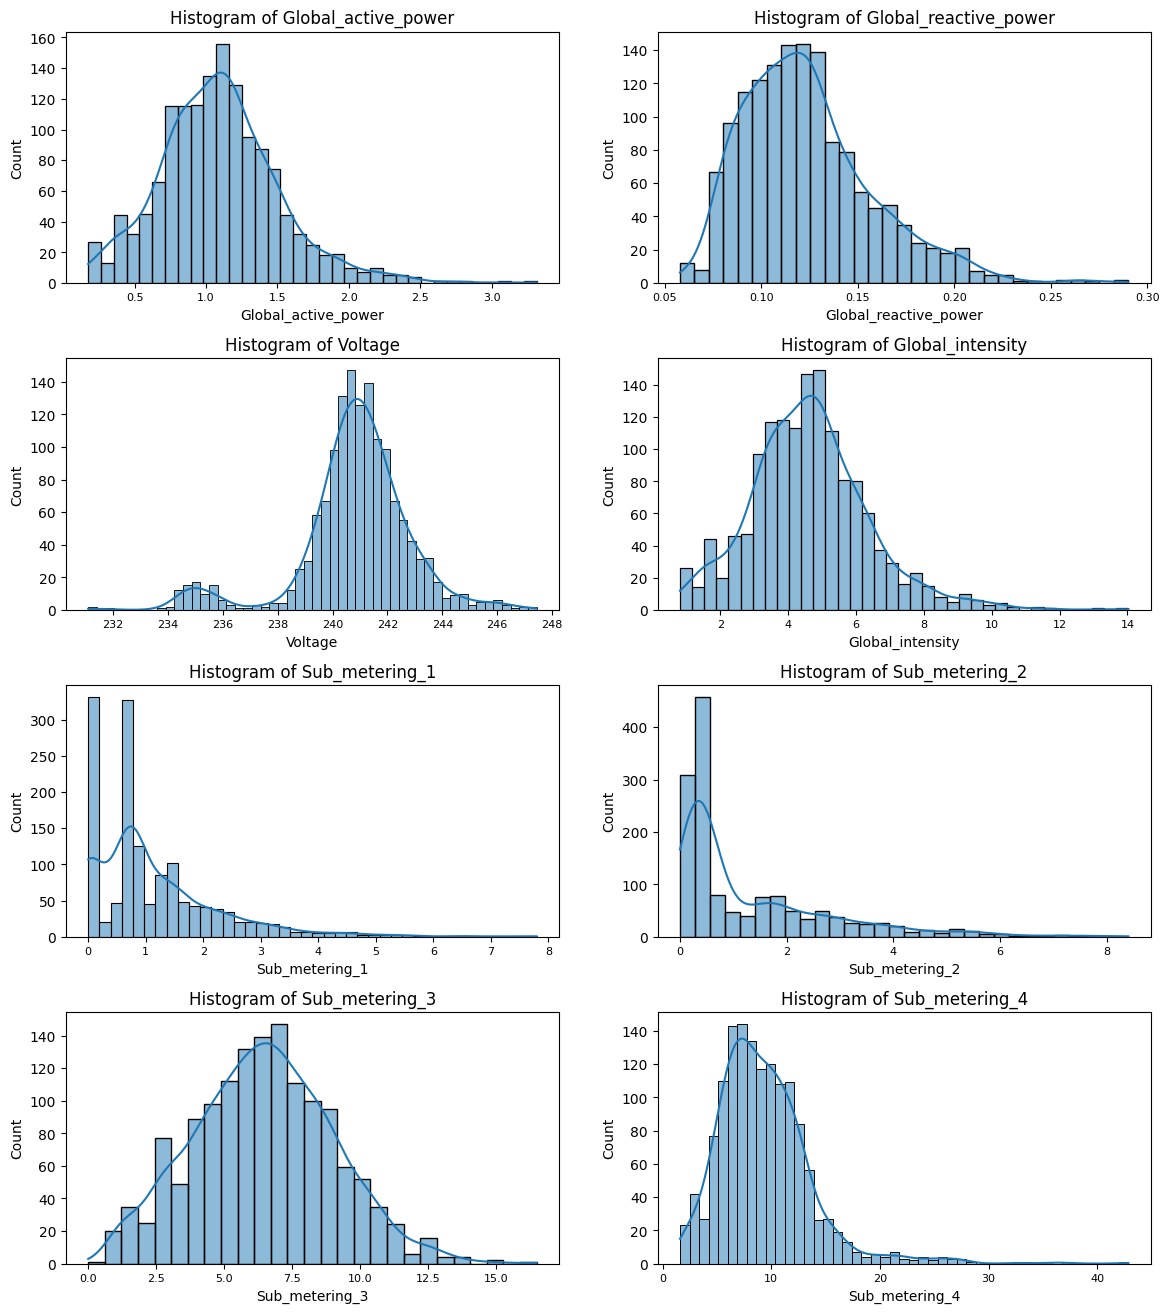

In [16]:
columns = df_daily.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14, 16), sharey=False)

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=df_daily[col], kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3)  # Adjust the vertical space between subplots

# Show the plot
plt.show()

In [ ]:
train_data = df.iloc[:int(0.8*len(df))]
test_data = df.iloc[int(0.8*len(df)):]

endog = df['Global_active_power']

# Fit the SARIMAX model
order = (1, 1, 1)  # Example order parameters (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Example seasonal order parameters (P, D, Q, s)
sarimax_model = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
sarimax_results = sarimax_model.fit()

# Make predictions
predictions = sarima_results.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

# Evaluate the model
# Example: Calculate mean squared error (MSE) or other relevant metrics
mse = ((predictions - test_data) ** 2).mean()
print("Mean Squared Error:", mse)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33985D-01    |proj g|=  1.11160D+00

At iterate    5    f=  1.63057D-01    |proj g|=  2.10477D-01

At iterate   10    f=  1.40937D-01    |proj g|=  3.08811D-01

At iterate   15    f=  1.02258D-01    |proj g|=  2.62671D-02

At iterate   20    f=  9.81061D-02    |proj g|=  2.52817D-02

At iterate   25    f=  9.67268D-02    |proj g|=  1.13660D-03

At iterate   30    f=  9.66801D-02    |proj g|=  6.26138D-03

At iterate   35    f=  9.65861D-02    |proj g|=  3.34403D-03

At iterate   40    f=  9.65720D-02    |proj g|=  1.77750D-04
  ys=-1.389E-06  -gs= 4.319E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac